## 1 Imports and Definitions

In [ ]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy.stats import pearsonr, spearmanr, kstest
import glob
from tqdm import tqdm
# collect garbage
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
import tensorflow_probability as tfp
from tensorflow_probability.python.stats import correlation, covariance
TF_CONFIG = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9), allow_soft_placement=True)

import matplotlib.colors as colors
from matplotlib import cm
plt.rcParams.update({'font.size': 14})
new_map = plt.cm.get_cmap('viridis', 12)

In [ ]:
#fun
def mae(a,b):
    'mean absolute error'
    return np.mean(np.abs(a-b))
def mde(a,b):
    'mean detection error'
    return np.mean((a==0)!=(b==0))
def rmse(a,b):
    'root mean squared error'
    return np.sqrt(np.mean((a-b)**2))
def bias(a,b):
    'some kind of bias'
    return np.mean(a)-np.mean(b)
def bias2(a,b):
    'some other kind of bias'
    return np.mean(b-a)/np.mean(b)*100
def cv(a):
    'CV'
    return np.std(a)/np.mean(a)

def to_numpy(ds, offset, hist, shuffle=True, dim0 = 'sample_number', dim1 = 'x', dim2 = 'y', dim3 = 'hist', newaxis=False):
    '''
    Generate numpy arrays from the xarray dataset that stores the samples
    
    In:
        ds: <xarray.Dataset>
            Dimensions:        (sample_number: 5684654, hist: 5, x: 11, y: 11)
            Coordinates:
              * sample_number  (sample_number) int64 6829552 6829553 ... 15425923 15425925
              * hist           (hist) int64 0 1 2 3 4
              * x              (x) int64 0 1 2 3 4 5 6 7 8 9 10
              * y              (y) int64 0 1 2 3 4 5 6 7 8 9 10
            Data variables:
                samples        (sample_number, hist, x, y) float32 0.07 0.03 ... 0.0 0.01
                reference      (sample_number, hist) float32 0.05 0.04 0.03 ... 0.05 0.12
                station_id     (sample_number) int64 2064 4112 2066 6161 ... 1964 4017 4078
                time           (sample_number) datetime64[ns] 2010-05-01 ... 2010-08-31T2...
                mhag           (sample_number, y, x) float64 1.992 1.995 ... 1.769 1.794
        offset: int
            should be in [0,5]. Specifies the extent of pixels included in a sample. 0 means only the pixel containing the rain gauge is considered.
        hist: int
            should be in [1,5]. Specifies the number of (past) timesteps included in a sample. 1 means only the current timestep is considered.
        shuffle: bool
            specifies whether sample order should be random. shuffles along sample_number dimension.
        dim_order: list of strings
            specifies order of 'x', 'y' and 'hist' dimensions.
        newaxis: bool
            specifies whether trivial feature dimension is appended, e.g. shape=(5,5) --> shape=(5,5,1).
    
    Out:
        X: np.array - float64
            Radar data for input in mm
            shape:(sample_number, hist, x, y, 1)
        H: np.array - float64
            Minimal measurement height above ground for input in km
            shape:(sample_number, x, y, 1)
        Y: np.array - float64
            Rain gauge reference for output in mm
            shape:(sample_number,)
        s: np.array - int
            station_id where sample comes from
            shape:(sample_number,)
        RY: np.array - float64
            RADOLAN pixel value above rain gauge in mm
            shape:(sample_number,)
        
    '''
    o_ext = ((len(ds.x)-1)/2)-offset # get difference of offset used to create the dataset and current offset
    h_ext = len(ds.hist)-hist # get difference of hist used to create the dataset and current hist
    # select new offset and hist as a subset
    ds = ds.isel({
        'hist':np.arange(h_ext, len(ds.hist)).astype(int),
        'x':np.arange(o_ext, len(ds.x)).astype(int),
        'y':np.arange(o_ext, len(ds.y)).astype(int),
    })
    
    # to numpy
    if newaxis:
        X = ds.samples.transpose(dim0,dim1,dim2,dim3,).values[:,:,:,:,np.newaxis]
    else:
        X = ds.samples.transpose(dim0,dim1,dim2,dim3,).values[:,:,:,:]
    
    X = np.round(X, decimals=2)
    H = ds.mhag.transpose(dim0,dim1,dim2,dim3,missing_dims='ignore').values[:,:,:,np.newaxis]
    Y = ds.reference.values[:,-1]
    Y1 = ds.R5x1.values
    Y = np.round(Y, decimals=2)
    Y1 = np.round(Y1, decimals=2)
    s = ds.station_id.values
    t = ds.time.values
    RY = ds.samples.values[:,-1,offset,offset,]
    RY = np.round(RY, decimals=2)
 
    # exlude negative gauge values
    X = X[Y>=0] # radar
    H = H[Y>=0] # minimal measurement height above ground
    s = s[Y>=0] # station id
    t = t[Y>=0] # time
    RY = RY[Y>=0] # RADOLAN pixel value above rain gauge
    Y = Y[Y>=0] # rain gauge reference
    Y1 = Y1[Y>=0] # 1 min rain gauge reference
    
    
    if shuffle:
        X, H, Y, Y1, s, t, RY = sklearn.utils.shuffle(X, H, Y, Y1, s, t, RY)
        return X, H, Y, Y1, s, t, RY
    else:
        return X, H, Y, Y1, s, t, RY

def score_table(rgn, predictions):
    print('Model:   '.ljust(15), *[pred.ljust(10) for pred in predictions])
    print('SRC:     '.ljust(15), 
          *[str(np.round(spearmanr(predictions[pred], rgn)[0],3)).ljust(10) for pred in predictions]
                  )
    print('PCC:     '.ljust(15), 
          *[str(np.round(pearsonr(predictions[pred], rgn)[0],3)).ljust(10) for pred in predictions]
                  )
    print('MAE:     '.ljust(15), 
          *[str(np.round(mae(predictions[pred], rgn),3)).ljust(10) for pred in predictions]
         )
    print('MDE:     '.ljust(15), 
          *[str(np.round(mde(predictions[pred], rgn),3)).ljust(10) for pred in predictions]
         )
    print('RMSE:    '.ljust(15), 
          *[str(np.round(rmse(predictions[pred], rgn),3)).ljust(10) for pred in predictions]
         )
    print('BIAS:    '.ljust(15), 
          *[str(np.round(bias(predictions[pred], rgn),4)).ljust(10) for pred in predictions]
         )
    print('BIAS2:   '.ljust(15), 
          *[str(np.round(bias2(predictions[pred], rgn),3)).ljust(10) for pred in predictions]
         )
    print('CV:      '.ljust(15), 
          *[str(np.round(cv(predictions[pred]),3)).ljust(10) for pred in predictions]
         )
    print('KS-test:   '.ljust(15), 
          *[str(np.round(kstest(predictions[pred], rgn)[0],3)).ljust(10) for pred in predictions]
         )
    print('')
    for pred in predictions:
        print(('Rain sum '+pred+': ').ljust(25),np.sum(predictions[pred]))

## 2 load data and get samples from datasets

In [4]:
# config
offset = 5
hist = 5
newaxis=True
dim0 = 'sample_number'
dim1 = 'hist'
dim2 = 'x'
dim3 = 'y'

In [ ]:
# VALIDATION -- Do not use in test section
ds_val =xr.open_dataset('/pd/home/polz-j/data/radolan_ai/validation/val_samples_v2_5x1.nc').load()
X_val, H_val, Y_val, Y1_val, s_val, t_val, RY_val = to_numpy(ds_val, offset=offset, hist=hist, shuffle=True, dim0 = dim0, dim1 = dim1, dim2 = dim2, dim3 = dim3, newaxis=newaxis)
ds_val.close()
gc.collect()
X_val, H_val, Y_val, Y1_val, RY_val = sklearn.utils.shuffle(X_val, H_val, Y_val, Y1_val, RY_val)
# TRAIN -- Do not use in test section
X = []
H = []
Y = []
RY = []
for fn in [
    '/pd/home/polz-j/data/radolan_ai/train/training_samples_2020_summer_v3_5x1.nc',
    '/pd/home/polz-j/data/radolan_ai/train/training_samples_2020_winter_v3_5x1.nc',
]:
    ds_train =xr.open_dataset(fn).load()
    x, h, y, y1, st, tt, ry = to_numpy(ds_train, offset=offset, hist=hist, shuffle=True, dim0 = dim0, dim1 = dim1, dim2 = dim2, dim3 = dim3, newaxis=newaxis)
    ds_train.close()# close datasets to free memory
    gc.collect()
    X.append(x)
    H.append(h)
    Y.append(y1)
    RY.append(ry)
    
X = np.concatenate(X, axis=0)
H = np.concatenate(H, axis=0)
Y = np.concatenate(Y, axis=0)
RY = np.concatenate(RY, axis=0)

# TEST -- Do not use in train section
ds_test =xr.open_dataset('/pd/home/polz-j/data/radolan_ai/test/test_samples_v2_5x1.nc').load()
X_test, H_test, Y_test, Y1_test, s_test, t_test, RY_test = to_numpy(ds_test, offset=offset, hist=hist, shuffle=False, dim0 = dim0, dim1 = dim1, dim2 = dim2, dim3 = dim3, newaxis=newaxis)
ds_test.close()
gc.collect()

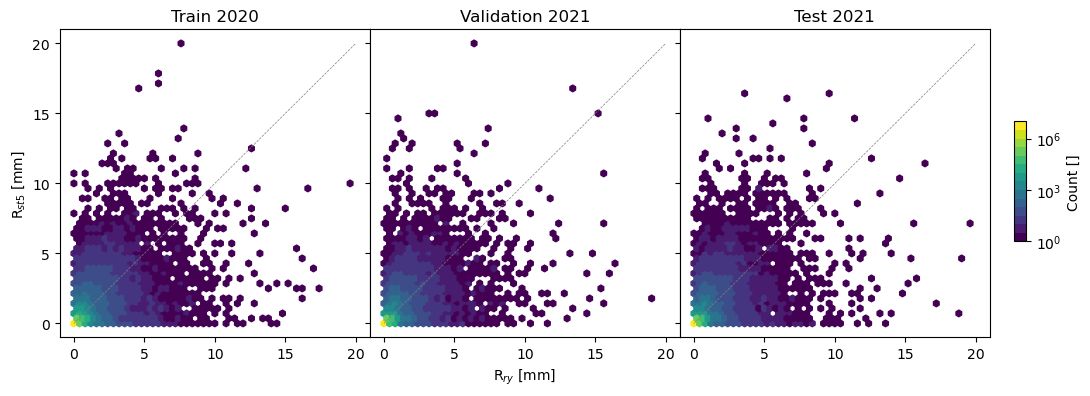

In [62]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)
limit = 20
new_map = plt.cm.get_cmap('viridis', 14)
norm = colors.LogNorm(vmin=1, vmax=1e7)
im = axs[0].hexbin(RY, np.sum(Y, axis=-1),gridsize=50, extent=[0,limit,0,limit], norm=norm, cmap=new_map)
axs[1].hexbin(RY_val, Y_val,gridsize=50, extent=[0,limit,0,limit], norm=norm, cmap=new_map)
axs[2].hexbin(RY_test, Y_test,gridsize=50, extent=[0,limit,0,limit], norm=norm, cmap=new_map)
axs[0].plot([0,limit],[0,limit],c='gray', linewidth=0.5, linestyle='dashed')
axs[1].plot([0,limit],[0,limit],c='gray', linewidth=0.5, linestyle='dashed')
axs[2].plot([0,limit],[0,limit],c='gray', linewidth=0.5, linestyle='dashed')
axs[0].set_title('Train 2020')
axs[1].set_title('Validation 2021')
axs[2].set_title('Test 2021')
axs[0].set_ylabel('R$_{st5}$ [mm]')
axs[1].set_xlabel('R$_{ry}$ [mm]')

axs[0].set_yticks(np.arange(0,25,5))
axs[0].set_xticks(np.arange(0,25,5))
axs[1].set_xticks(np.arange(0,25,5))
axs[2].set_xticks(np.arange(0,25,5))
cax = plt.axes([0.92, 0.35, 0.01, 0.3])
plt.colorbar(im, cax=cax)
cax.set_ylabel('Count []')
plt.subplots_adjust(wspace=0)
plt.savefig('plots/paper/datasets.png', dpi=600)
plt.show()

## 3 define model

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Reshape, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Conv2D, GlobalMaxPooling2D, Conv3D, AveragePooling3D
from tensorflow.keras.activations import relu

In [ ]:
def residual_layer(input_layer, filters):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    conv1 = tf.keras.layers.Conv3D(
        filters, 3, strides=1, padding="same", kernel_initializer=initializer
    )(input_layer)
    conv1 = tf.keras.layers.ReLU()(conv1)
    conv1 = tf.keras.layers.Conv3D(
        filters, 3, strides=1, padding="same", kernel_initializer=initializer
    )(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)
    conv2 = tf.keras.layers.Conv3D(
        filters,
        kernel_size=(1, 1, 1),
        strides=1,
        padding="same",
        kernel_initializer=initializer,
    )(input_layer)

    return tf.keras.layers.Add()([conv1, conv2])

In [27]:
# add model layers
input1 = Input(shape=(5, 11, 11, 1))
x1 = residual_layer(input1, 32)
x1 = residual_layer(x1, 32)
x1 = Conv3D(64, kernel_size=(3, 3, 3), padding="valid", activation="relu")(x1)
x1 = AveragePooling3D(pool_size=(2, 2, 2))(x1)

input2 = Input(shape=(11, 11, 1))
x2 = Conv2D(
    4,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding="valid",
)(input2)
x2 = Conv2D(8, kernel_size=(2, 2), strides=(1, 1), padding="valid", activation="relu")(
    x2
)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)

x = Concatenate()(
    [Reshape((4, 4, 64))(x1), x2],
)
x = Conv2D(
    64,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding="same",
)(x)
x = Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(
    32,
    kernel_size=(2, 2),
    strides=(1, 1),
    padding="same",
)(x)
x = Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding="same", activation="relu")(x)
x = GlobalMaxPooling2D()(x)
x = Dense(64, activation="relu")(x)
out = Dense(5, activation="relu")(x)

modelCNN = Model(inputs=[input1, input2], outputs=out)
modelCNN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5, 11, 11, 1 0                                            
__________________________________________________________________________________________________
conv3d_10 (Conv3D)              (None, 5, 11, 11, 32 896         input_3[0][0]                    
__________________________________________________________________________________________________
re_lu_6 (ReLU)                  (None, 5, 11, 11, 32 0           conv3d_10[0][0]                  
__________________________________________________________________________________________________
conv3d_11 (Conv3D)              (None, 5, 11, 11, 32 27680       re_lu_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
)

modelCNN.compile(
    optimizer=optimizer,
    loss = 'mean_squared_error',
    metrics=['mae',])

## Train

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.00001, patience=100, restore_best_weights=True,)
mc = ModelCheckpoint('resnet_best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #
batch_size = 1000
gc.collect()

In [ ]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, ids, batch_size, n_iterations, shuffle=True):
        self.batch_size = batch_size
        self.n_iterations = n_iterations
        self.ids = ids

        self.n = len(ids)
        self.shuffle = shuffle

    def on_epoch_end(self):
        pass

    def __getitem__(self, index):
        batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        x, y = load_data(batch)
        return x, y

    def __len__(self):
        return self.n // self.batch_size


def load_data(ids):
    Xt = []
    Ht = []
    Yt = []

    for i in ids:
        x = X[i]
        h = H[i]
        y = Y[i]

        Xt.append(x)
        Ht.append(h)
        Yt.append(y)

    return [np.array(Xt), np.array(Ht)], np.array(Yt)


class PredGen(tf.keras.utils.Sequence):
    def __init__(self, ids, batch_size, shuffle=True):
        self.batch_size = batch_size
        self.ids = ids

        self.n = len(ids)
        self.shuffle = shuffle

    def on_epoch_end(self):
        pass

    def __getitem__(self, index):
        batch = self.ids[
            index * self.batch_size : min([self.n, (index + 1) * self.batch_size])
        ]
        x = load_test_data(batch)
        return x

    def __len__(self):
        return (self.n // self.batch_size) + 1


class PredGentrain(tf.keras.utils.Sequence):
    def __init__(self, ids, batch_size, shuffle=True):
        self.batch_size = batch_size
        self.ids = ids

        self.n = len(ids)
        self.shuffle = shuffle

    def on_epoch_end(self):
        pass

    def __getitem__(self, index):
        batch = self.ids[
            index * self.batch_size : min([self.n, (index + 1) * self.batch_size])
        ]
        x, _ = load_data(batch)
        return x

    def __len__(self):
        return (self.n // self.batch_size) + 1


def load_test_data(ids):
    Xt = []
    Ht = []

    for i in ids:
        x = X_test[i]
        h = H_test[i]

        Xt.append(x)
        Ht.append(h)

    return [np.array(Xt), np.array(Ht)]


In [ ]:
ids=np.arange(int(len(X)/batch_size)*batch_size)
train_gen = DataGen(ids, batch_size = batch_size, n_iterations = 10)

In [ ]:
# training the model
modelCNN.fit(
    train_gen,
    epochs=1000,
    verbose=1,
    validation_data=(
        [
            X_val[:100000],
            H_val[:100000],
        ],
        Y1_val[:100000],
    ),
    callbacks=[PlotLossesKeras(), es, mc],
)


In [ ]:
# load best model
modelCNN = tf.keras.models.load_model('resnet_best_model.h5',)

In [ ]:
# predict validation data
pred_val = modelCNN.predict([X_val,H_val,], batch_size=1000,verbose=1)

In [ ]:
# rounding
pred_val[pred_val<0.005] = 0

In [73]:
# compute multiplicative bias
correction_factor = np.sum(Y1_val)/np.sum(pred_val)
correction_factor

1.1762937165496112